# Notebook for Using Regression Neural Network to Extract Tau from trEFM Data Based on: 

# *A Robust Neural Network for Extracting Dynamics from Time-Resolved Electrostatic Force Microscopy Data*

Madeleine D. Breshears, Rajiv Giridharagopal, Justin Pothoof, and David S. Ginger

Corresponding author: David S. Ginger (dginger@uw.edu)

Prepared by Madeleine D. Breshears (mdbresh@uw.edu)

In [1]:
import NNFFtrEFM
import numpy as np
import matplotlib.pyplot as plt
import shap
import torch

C:\Users\mdbre\anaconda3\lib\site-packages\pytorch_lightning\metrics\__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(


## Downloading the Data

In order to download the relevant data, please follow this [link](https://drive.google.com/file/d/1TPy4p19gUE24J8rw239gMV250QI5Dywz/view?usp=sharing) and click the Download button in the upper right corner of the webpage. You should be directed to save a zip file containing the data. Extract the files in the same folder in which you run this notebook

## Loading and Using the Model

First let's load our data, an image.

In [2]:
image = np.load('ff03.npy') # already prepared according to documentation listed in NNFFtrEFM file.
tfp = np.load('tfp.npy') # t_FP image for comparison.
topo = np.load('topo.npy') # topography image for comparison.

Now we can load the trained model used in the publication.

In [3]:
model = NNFFtrEFM.Network().load_from_checkpoint('trained_network.ckpt')

To get predictions and standard deviations, we will use the following function:

In [4]:
pred, std = NNFFtrEFM.extract_tau(model, image, num=50, dists=False, im=True)

Let's visualize the data.

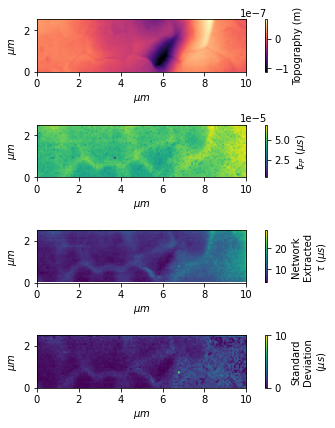

In [5]:
fig, ax = plt.subplots(nrows=4, figsize=(6,6))

a = ax[0].imshow(topo, cmap='magma', extent=[0,10,0,2.5])
ax[0].set_xlabel('$\mu m$')
ax[0].set_ylabel('$\mu m$')
plt.colorbar(a,ax=ax[0],label='Topography (m)')

b = ax[1].imshow(tfp, extent=[0,10,0,2.5])
ax[1].set_xlabel('$\mu m$')
ax[1].set_ylabel('$\mu m$')
plt.colorbar(b,ax=ax[1],label='$t_{FP}$ ($\mu s$)')

c = ax[2].imshow(pred, extent=[0,10,0,2.5])
ax[2].set_xlabel('$\mu m$')
ax[2].set_ylabel('$\mu m$')
plt.colorbar(c,ax=ax[2],label='Network\nExtracted\n$\\tau$ ($\mu s$)')

d = ax[3].imshow(std, extent=[0,10,0,2.5])
ax[3].set_xlabel('$\mu m$')
ax[3].set_ylabel('$\mu m$')
plt.colorbar(d,ax=ax[3],label='Standard\nDeviation\n($\mu s$)')

plt.tight_layout()

Note the heterogeneity in the tFP image, where (presumed) grain boundaries show longer charging behavior than (presumed) grain centers. This heterogeneity is matched in the network-extracted tau image. 

Also note in the tFP image the one "cold" pixel. It is very unlike its neighbors, and is likely noise that we can attribute to an error in the curve fitting function used to extract tFP. If we used the traditional tFP-tau calibration method (see Note S1 in publication), that noise would be maintained. The network-extracted image uses the entire instantaneous frequency signal, meaning it is more robust against noise.

## Using SHAP to Explore the Model

In the publication, we use SHapley Additive exPlanations to visualize the contributions of individual features to the model output. Here is an example of using SHAP to evaluate a single pixel.

In [6]:
pixel = image[10,10,:]

In [7]:
time = np.linspace(0.2,1.8,98)

Here is the pixel we've selected, where the 0th and 1st indices contain k and Q respectively, and the following 98 indices contain the cropped (from 0.2 ms to 1.8 ms of the 2 ms experiment), resampled, and normalized instantaneous frequency data.

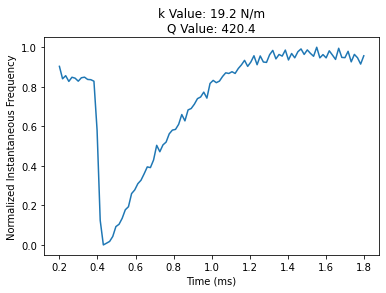

In [8]:
plt.plot(time, pixel[2:])
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Instantaneous Frequency')
plt.title('k Value: {} N/m\nQ Value: {}'.format(pixel[0],pixel[1]))
plt.show()

Now we'll instantiate a SHAP explainer. Read more about SHAP [here](https://shap.readthedocs.io/en/latest/index.html).

In [9]:
test_inputs = np.load('test_inputs.npy') # 3,000 simulated test input arrays containing k, Q, and omega(t).

In [10]:
def wrapper_for_shap(a):
    '''
    For our purposes, SHAP requires a wrapper function that intakes some representative data
    and outputs the model prediction. This is different from the NNFFtrEFM.extract_tau() function because
    we do not need it to return a standard deviation or use quasi-ensembling to explain the model.
    
    Inputs --
    
    a : Numpy array where the -1 dimension is 100.
    
    Returns -- 
    
    res : Model prediction. Be sure to have loaded the trained model in this notebook already.
    '''
    a_t = torch.from_numpy(a).float()
    res = model(a_t).detach().numpy()
    return res

In [11]:
explainer = shap.KernelExplainer(wrapper_for_shap,
                                 shap.sample(test_inputs, nsamples=100))
# instantiating the explainer involves giving it several inputs to sample from in order to learn the model outputs 
# in the presence and absence of all the features. See Note S3 in the publication.

Now we can calculate the SHAP values for our pixel.

In [13]:
shap_vals = explainer.shap_values(pixel)[0] 
shap_vals.shape

(100,)

Let's look at the SHAP values for k and Q and visualize the SHAP values for the instantaneous frequency.

In [14]:
print('The SHAP Value for k is: {}'.format(shap_vals[0]))
print('The SHAP Value for Q is: {}'.format(shap_vals[1]))

The SHAP Value for k is: 0.0
The SHAP Value for Q is: 4.739505321176985


In this case, k was not influential on the model output for this pixel. Q, however, was influential. The Q value associated with the cantilever that we used to collect this image indicated to the network that the expected tau value corresponding to these data is larger than the mean model output (approximatley 85 us). We know this because the corresponding SHAP value is positive.

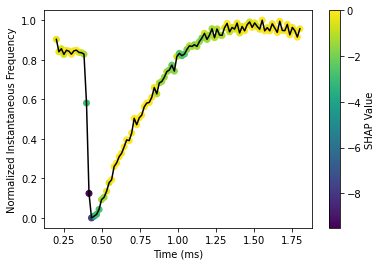

In [15]:
plt.plot(time, pixel[2:],color='k')
plt.scatter(time, pixel[2:],c=shap_vals[2:])
plt.xlabel('Time (ms)')
plt.ylabel('Normalized Instantaneous Frequency')
plt.colorbar(label='SHAP Value')
plt.show()

Text(0, 0.5, 'Counts')

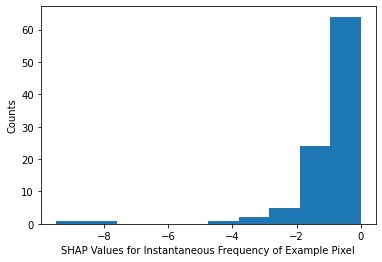

In [16]:
plt.hist(shap_vals[2:])
plt.xlabel('SHAP Values for Instantaneous Frequency of Example Pixel')
plt.ylabel('Counts')

Overall, we see that all SHAP values for this example pixel are negative. This tells us that these instantaneous frequency features indicate to the trained network that the expected tau value is less than the average training tau value (approximately 85 us). We can see that the highest magnitude SHAP values are concentrated along the initial frequency shift and relaxation of the instantaneous frequency trace.

## Training your own network using this framework

If you want to train your own network according to this framework, we suggest checking out the FFTA package [here](https://ffta.readthedocs.io/en/latest/) to learn how to simulate your own training data. Below is some code to get you started on the training process.

In [17]:
new_model = NNFFtrEFM.Network()

In [18]:
training_data = np.empty((10000,101)) # note that the -1 dimension of whatever training data you choose to use must be 101
# training_data[:,0] is the target or label
# training_data[:,1] is the k value(s)
# training_data[:,2] is the Q value(s)
# training_data[:,3:] is the resampled, normalized instantaneous frequency trace

In [19]:
# NNFFtrEFM.train_model(new_model, training_data, path='new_model_checkpoints/', epochs=100, gpu=True)
# Uncomment the above line and change the variable names according to the documentation in NNFFtrEFM

#### Some notes on the training data:

If you choose to simulate your own training data using the FFTA package, the only requirement is the shape of the data. For the publication, we prepared the simulated training data accordingly:
- Added Gaussian noise to the raw deflection.
- Short time Fourier transform demodulation method with either 60 or 70 us resolution.
- Cropped the instantaneous frequency data from 0.2 ms to 1.8 ms.
- Normalized the data between 0 and 1.
- Resampled the data to ensure it was 98 indices in length.